# Protein Latent Diffusion

We have explored protein generation with EGNN as well as EDM in the previous sections. Both of which enforce the requirements for equivariant for protein generation, which are more restrictive as it focus on more local geometric consistency. We attempted a simpler version of protein generation by capturing its distribution within the latent representation, then perform diffusion process with the latent representation. After which we decode the denoised latent representation back original dimensions. 

## Load Required Libraries
Making use of Deep Graph Library and PyTorch, we build the model with the provided tools within these 2 libraries. Along with some visualization tools such as Matplotlib. 


In [51]:

import data_read
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import dgl
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from dgl.nn import SAGEConv, AvgPooling, GraphConv
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import StandardScaler
import numpy as np

## Dataset

for the dataset, we have opted for FoldingDiff CATH S40 training dataset available in https://zenodo.org/records/8388270, we also selected the PDB files which has consistent/clean data for our training purpose. 

In [48]:
pdb_dir ='data/dompdb/'
list_path = 'data/clean_pdb_id.txt'

In [49]:
with open(list_path) as file:
    lines = [line.rstrip() for line in file]

print(len(lines))

31065


We have 31065 protein data. Each protein have varying sizes of long sequence.

## Plot Protein
Plotting the protein to visualize how each protein looks.

In [47]:
def plot_protein(frame):
    """
    Take in a list of 3D coordinates representing amino acids and plot a protein diagram
    Args: 
        frame: 3D coordinates generated by backbone. Shape - n_aa x 4 x 3
            second dimension representing N, CA, C, CB
    Returns: -
    """
    N_coords, CA_coords, C_coords, CB_coords = [], [], [], []
    for aa in frame:
        N_coords.append(aa[0, :])
        CA_coords.append(aa[1, :])
        C_coords.append(aa[2, :])
        CB_coords.append(aa[3, :])
    
    N_coords = np.stack(N_coords)
    CA_coords = np.stack(CA_coords)
    C_coords = np.stack(C_coords)
    CB_coords = np.stack(CB_coords)
    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(N_coords[:, 0], N_coords[:, 1], N_coords[:, 2], label='N', color='blue')
    ax.scatter(CA_coords[:, 0], CA_coords[:, 1], CA_coords[:, 2], label='CA', color='green')
    ax.scatter(C_coords[:, 0], C_coords[:, 1], C_coords[:, 2], label='C', color='red')
    ax.scatter(CB_coords[:, 0], CB_coords[:, 1], CB_coords[:, 2], label='CB', color='orange')
    
    ax.plot(C_coords[:, 0], C_coords[:, 1], C_coords[:, 2], color='black', label='Backbone (C-C)')
    
    # Labeling
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')
    ax.legend()
    ax.set_title('Protein')
    
    # Show plot
    plt.show()


Same process to get the backbone of the protein from each PDB file. 

In [44]:
def input_generation(pdb_path):
    frames, seq = data_read.get_backbone(pdb_path)
    frames = torch.from_numpy(frames[0]); seq = seq[0]
    frames = frames.to(torch.float32)
    n = len(seq)

    return frames, seq

data/dompdb/12asA00


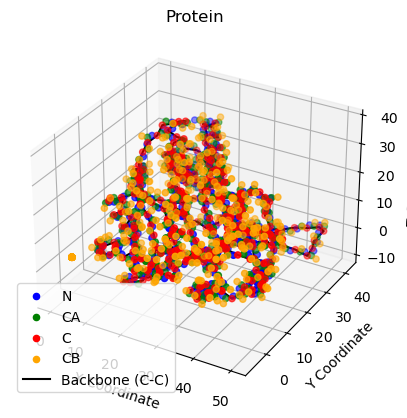

In [50]:
# See the first protein file
pdb_name = lines[0]
pdb_path = pdb_dir + pdb_name
print(pdb_path)

frames, seq = input_generation(pdb_path)
plot_protein(frames)


## Process Data
We will process the data such that the required graphs, frames, sequences are constructed for model building process.

In [52]:
# the database is quite big, limiting the number of graph/protein to avoid oom issue
num_graph = 500

In [9]:
def process_protein_data(num_graph):
    """
    Args:
        num_graph (int): number of graphs to be extracted from the list
    Returns: 
        graphs - graphs contructed from the protein files - length = num_graph
        list_of_frames - a list of 3D coordinates [(n_aa, 4, 3)], length = num_graph
        list_of_seqs = a list of aa sequences [(n_aa, 4, 3)], length = length = num_graph
        num_categories = number of unique characters for the sequences
    """
    file_names = lines[:num_graph]
    graphs, list_of_frames, list_of_seqs = [], [], []
    long_seq = ""
    for protein in file_names:
        pdb_path = pdb_dir + protein
        frames, seq, _ = input_generation(pdb_path)
        i_seq = data_read.encode(seq)
        num_nodes = len(seq) * 4
        g = dgl.graph(([], []), num_nodes=num_nodes)
        g = dgl.add_self_loop(g)
        graphs.append(g)
        
        list_of_frames.append(frames)
        list_of_seqs.append(i_seq)
        long_seq += seq
    
    num_categories = len(set(long_seq))
    return graphs, list_of_frames, list_of_seqs, num_categories
    

In [32]:
graphs, list_of_frames, list_of_seqs, num_categories = process_protein_data(num_graph)


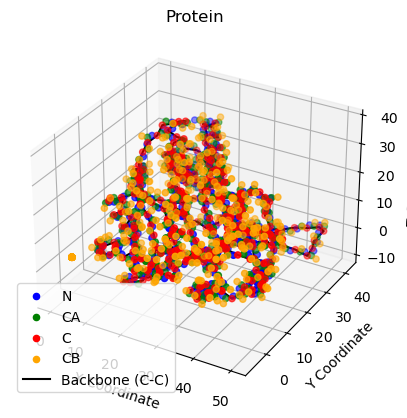

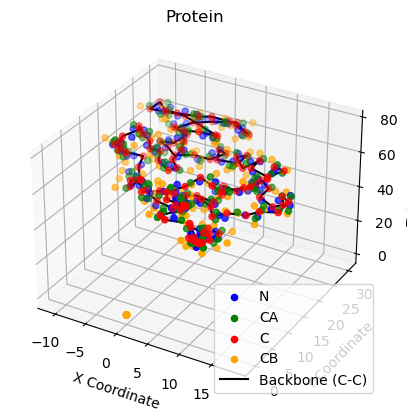

In [11]:
# plot the first 2 proteins
plot_protein(list_of_frames[0])
plot_protein(list_of_frames[1])

## Create the Dataset

In [12]:
class GraphDataset(Dataset):
    def __init__(self, graphs, node_features, coordinates):
        self.graphs = graphs
        self.node_features = node_features
        self.coordinates = coordinates

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        coords = self.coordinates[idx]
        features = self.node_features[idx]
        return self.graphs[idx], features, coords

In [33]:
dataset = GraphDataset(graphs, list_of_seqs, list_of_frames)

In [14]:
def collate_fn(batch):
    """
    Collates a batch of graphs and their features into a batched graph.
    """
    graphs, features, coordinates = map(list, zip(*batch))
    batched_graph = dgl.batch(graphs)

    # Combine node features across the batch
    batch_categorical = torch.cat(features)
    batch_continuous = torch.cat(coordinates)

    return batched_graph, batch_categorical, batch_continuous

In [34]:
dataset_size = len(lines) # 31065
dataset_size = num_graph

# Define the split ratios
train_ratio, val_ratio, test_ratio = 0.8, 0.1, 0.1
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

In [35]:
batch_size = 4  # Example batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

## Latent Diffusion

In [25]:
class BatchedLatentDiffusionAutoencoder(nn.Module):
    def __init__(self, num_categories, embedding_dim, continuous_dim, latent_dim, diffusion_steps):
        super().__init__()
        
        # Embedding layer for categorical features
        self.embedding = nn.Embedding(num_categories, embedding_dim)
        
        # Graph convolutional encoder
        input_dim = embedding_dim + continuous_dim
        self.gcn_encoder = GraphConv(input_dim, latent_dim)
        
        # Diffusion process
        self.diffusion_steps = diffusion_steps
        self.noise_scheduler = self.get_noise_scheduler(diffusion_steps)
        self.denoising_model = GraphConv(latent_dim, latent_dim)
        
        # Graph convolutional decoder
        self.gcn_decoder = GraphConv(latent_dim, input_dim)
        
        # Output heads for reconstruction
        self.cat_decoder = nn.Linear(embedding_dim, num_categories)  # Categorical reconstruction
        self.cont_decoder = nn.Linear(continuous_dim, continuous_dim)  # Continuous reconstruction

    def get_noise_scheduler(self, steps):
        # Linear noise schedule for simplicity
        return torch.linspace(0.01, 0.1, steps)

    def forward(self, g, categorical, continuous, t):
        # Node embeddings for categorical features
        rep_cat = torch.tensor([num for num in categorical for _ in range(4)])
        cat_embedded = self.embedding(rep_cat)
        continuous = continuous.view(-1, 3)
        # Concatenate embeddings with continuous features
        node_features = torch.cat([cat_embedded, continuous], dim=-1)
        # Encode node features into latent space
        latent = self.gcn_encoder(g, node_features)
        
        # Diffusion process
        noise_level = self.noise_scheduler[t]
        noise = torch.randn_like(latent) * noise_level
        noisy_latent = latent + noise
        
        # Denoise latent space
        denoised_latent = self.denoising_model(g, noisy_latent)
        
        # Decode to original feature space
        decoded = self.gcn_decoder(g, denoised_latent)
        
        # Split decoded output
        decoded_cat = self.cat_decoder(decoded[:, :cat_embedded.size(-1)])
        decoded_cont = self.cont_decoder(decoded[:, cat_embedded.size(-1):])
        
        decoded_cat = decoded_cat[::4, :]
        decoded_cont = decoded_cont.view(-1, 4, 3)
        return decoded_cat, decoded_cont, latent, denoised_latent

## Loss Function

In [18]:
# Loss functions
def diffusion_loss(latent, denoised_latent, noise):
    return F.mse_loss(denoised_latent, latent - noise)

def reconstruction_loss(original_cat, reconstructed_cat, original_cont, reconstructed_cont):
    # Categorical loss
    cat_loss = nn.CrossEntropyLoss()(reconstructed_cat, original_cat)
    
    # Continuous loss
    cont_loss = nn.MSELoss()(reconstructed_cont, original_cont)
    
    # Combine losses
    return cat_loss + cont_loss

# Training

In [26]:
# Hyperparameters
embedding_dim = 20   # Embedding size for categorical data
continuous_dim = 3  # Dimensionality of continuous features
latent_dim = 100     # Latent space size

In [41]:
# Initialize the model
diffusion_steps = 100
model = BatchedLatentDiffusionAutoencoder(num_categories=num_categories, embedding_dim=embedding_dim, continuous_dim=continuous_dim, latent_dim=latent_dim, diffusion_steps=diffusion_steps)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(50):
    epoch_loss = 0
    
    for batched_graph, batch_categorical, batch_continuous in train_loader:
        # Randomly sample a diffusion step
        t = torch.randint(0, diffusion_steps, (1,)).item()
        
        # Forward pass
        reconstructed_cat, reconstructed_cont, latent, denoised_latent = model(
            batched_graph, batch_categorical, batch_continuous, t
        )
        
        # Compute losses
        noise = torch.randn_like(latent) * model.noise_scheduler[t]
        diffusion_loss = F.mse_loss(denoised_latent, latent - noise)
        reconstruction_loss = (
            nn.CrossEntropyLoss()(reconstructed_cat, batch_categorical) +
            nn.MSELoss()(reconstructed_cont, batch_continuous)
        )
        
        # Combine losses
        loss = diffusion_loss + reconstruction_loss
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1, Loss: 50491.3146
Epoch 2, Loss: 13956.7798
Epoch 3, Loss: 5499.8409
Epoch 4, Loss: 2874.6685
Epoch 5, Loss: 1626.0706
Epoch 6, Loss: 951.9982
Epoch 7, Loss: 562.6514
Epoch 8, Loss: 338.8049
Epoch 9, Loss: 218.3136
Epoch 10, Loss: 388.2393
Epoch 11, Loss: 361.7043
Epoch 12, Loss: 281.3534
Epoch 13, Loss: 321.3211
Epoch 14, Loss: 399.7355
Epoch 15, Loss: 125.1765
Epoch 16, Loss: 113.3102
Epoch 17, Loss: 243.5633
Epoch 18, Loss: 708.7221
Epoch 19, Loss: 228.2333
Epoch 20, Loss: 146.3299
Epoch 21, Loss: 157.4214
Epoch 22, Loss: 158.8813
Epoch 23, Loss: 623.0815
Epoch 24, Loss: 513.9343
Epoch 25, Loss: 179.2337
Epoch 26, Loss: 534.5173
Epoch 27, Loss: 553.0391
Epoch 28, Loss: 287.1468
Epoch 29, Loss: 261.8583
Epoch 30, Loss: 230.5672
Epoch 31, Loss: 224.5607
Epoch 32, Loss: 741.3098
Epoch 33, Loss: 341.0561
Epoch 34, Loss: 1068.1981
Epoch 35, Loss: 116.8552
Epoch 36, Loss: 111.6280
Epoch 37, Loss: 166.5929
Epoch 38, Loss: 117.5594
Epoch 39, Loss: 114.0449
Epoch 40, Loss: 326.2370
E

In [28]:
def reverse_diffusion(model, g, num_nodes, diffusion_steps, embedding_dim, continuous_dim, latent_dim):
    # Initialize random noise (latents) for generation
    noise_level = model.noise_scheduler[diffusion_steps - 1]  # Start with the highest noise level
    in_feats = embedding_dim + continuous_dim
    latent = torch.randn(num_nodes, latent_dim).to(g.device)  # Random noise in latent space

    # Reverse the diffusion process (denoising step)
    for t in reversed(range(diffusion_steps)):
        # Denoise the latent using the trained model
        denoised_latent = model.denoising_model(g, latent)
        
        # Apply the noise scheduler at timestep t
        noise_level = model.noise_scheduler[t]
        latent = (latent - noise_level * denoised_latent) / torch.sqrt(1 - noise_level**2)
        
    # Decode the latent to original feature space
    decoded = model.gcn_decoder(g, latent)
    
    # Split decoded output into categorical and continuous
    decoded_cat = model.cat_decoder(decoded[:, :model.embedding.embedding_dim])
    decoded_cont = model.cont_decoder(decoded[:, model.embedding.embedding_dim:])
    decoded_cat = decoded_cat[::4, :]
    decoded_cont = decoded_cont.view(-1, 4, 3).detach().numpy()
    
    # Convert categorical values to the most likely class (argmax)
    cat_output = torch.argmax(F.softmax(decoded_cat, dim=-1), dim=-1)
    
    # Return generated categorical and continuous data
    return cat_output, decoded_cont

In [42]:
generated_seqs = []
for batched_graph, batch_categorical, batch_continuous in val_loader:
    individual_graphs = dgl.unbatch(batched_graph)
    # Check the unbatched graphs
    for i, g in enumerate(individual_graphs):
    
        num_nodes = g.num_nodes()
        generated_cat, generated_cont = reverse_diffusion(model, g, num_nodes, diffusion_steps=model.diffusion_steps, embedding_dim=embedding_dim, continuous_dim=continuous_dim, latent_dim=latent_dim)
        generated_seqs.append(generated_cont)

50


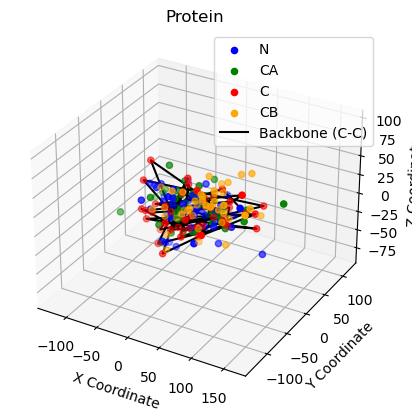

In [43]:
print(len(generated_seqs))
plot_protein(generated_seqs[1])

In [ ]:

def generate_res_object(pdb_seq,coords):
    residues = []
    for i ,aa in enumerate(pdb_seq, start=0):
        if aa == "G":
            res = {"name":seq3(aa),"atoms":[("N", coords[i,0,:].tolist()), ("CA", coords[i,1,:].tolist()), ("C", coords[i,2,:].tolist())]}
        else:
            res = {"name":seq3(aa),"atoms":[("N", coords[i,0,:].tolist()), ("CA", coords[i,1,:].tolist()), ("C", coords[i,2,:].tolist()),("CB", coords[i,3,:].tolist())]}
        residues.append(res)
    return residues

In [ ]:

def generate_pdb(pdb_id,residues):
    builder = StructureBuilder.StructureBuilder()
    
    # Create a structure object
    builder.init_structure("Predicted eGNN Backbone ")
    builder.init_model(0)
    builder.init_chain("A")  # Single chain "A"
    builder.init_seg(" ")
    
    for res_id, residue in enumerate(residues, start=1):
        builder.init_residue(residue["name"], " ", res_id, " ")
    
        # Add atoms to the residue
        for atom_name, coords in residue["atoms"]:
            builder.init_atom(atom_name, coords, 1.0, 1.0, " ", atom_name, res_id, atom_name[0])

    structure = builder.get_structure()
    io = PDBIO()
    io.set_structure(structure)
    io.save(pdb_id+".pdb")